# Ford GoBike Trips Analysis

## Investigation Overview

In this investigation, I wanted to look at Ford GoBike trips data and analyze  the behavioral of the users. The main focus was on:
* The number of trips
* The trip duration
* The trip distance
* The members user type
* The members age

## Dataset Overview
There are 183,412 trips in the dataset (after data cleaning) mainly about the bike trips information such as trip duration and many member information like member age, gender and user type.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# Drop NA records
df.dropna(inplace=True, subset=['member_birth_year'])
df.dropna(inplace=True, subset=['start_station_id'])


# adjust the data types

## change the string of start time & end time to datetimes 

df['start_time'] = df.start_time.astype('datetime64[ns]')

df['end_time'] = df.end_time.astype('datetime64[ns]')

## change the floating member_birth_year and stations IDs to int
df['member_birth_year'] = df.member_birth_year.astype('int32')

df['start_station_id'] = df.start_station_id.astype('int32')

df['end_station_id'] = df.end_station_id.astype('int32')


In [4]:
# Roll up the duration dimension to the level of the minutes
df['duration_in_mins'] = round(df['duration_sec']/60,2)

# Add new dimension, the member age

from datetime import date

df['member_age'] = int(str(date.today())[:4]) - df['member_birth_year']

# Distribute the age in buckets ranging from younger than 30 years old to older than 70 yeras old.
age_bins= [20,30,40,50,60,70,999]
age_buckets_labels = ['<30','<40','<50','<60', '<70', '>70']
df ['member_age_bucket' ] = pd.cut(df['member_age'], bins = age_bins, labels=age_buckets_labels, right=False)


# The distance can be calculated based on the latitude and longitude of the start and end stations 

df['trip_distance'] = np.sqrt((df.start_station_latitude - df.end_station_latitude)**2 + (df.start_station_longitude - df.end_station_longitude)**2 )*100

# Adding some new dimension rolled up from the start time data.
df['trip_start_day']  = df.start_time.dt.day_name()

# Adding the proper order of the weekdays
weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


df['trip_start_hour'] = df.start_time.dt.hour

In [5]:
## show countplot of a dimension
main_color = '#33A8FF'

def show_countplot (x,figsize=[15,15], title="Put Title", xtitle="", ytitle=""):
  plt.figure(figsize=figsize)
  sb.countplot(data=df, x=x, color= main_color , order=df[x].value_counts().index)
  plt.title(title)
  plt.xlabel( xtitle)
  plt.ylabel(ytitle)
  plt.show()

def show_pieplot(data_frame,column_name, figsize=[10,10], title=''):
  plt.figure(figsize=figsize)
  labels = data_frame[column_name].value_counts().index
  values = data_frame[column_name].value_counts().values

  plt.title(title)
  plt.pie(values, labels=labels, autopct='%1.2f%%',shadow=True, startangle=0, colors = [main_color, '#9e7a36'])
  plt.show()



## Ford GoBike Members Behavior

The most of rides made were for subscribers of Ford GoBike, they represent 90.11% of the total trips made within the dates of the data set. 
Also, most of those trips are made in weedays (the least number of trips for subscribers is on weekends) and at 8:00AM and 5:00PM hours exactly.  


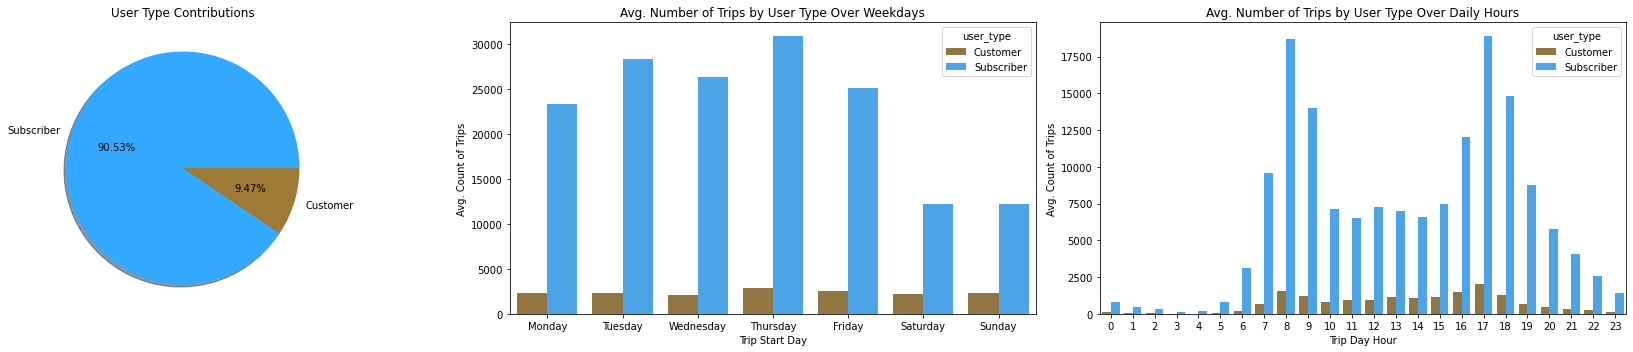

In [6]:
plt.figure(figsize=[24, 5]);


labels = df['user_type'].value_counts().index
values = df['user_type'].value_counts().values
plt.subplot(1,3,1)
plt.title('User Type Contributions')

plt.pie(values, labels=labels, autopct='%1.2f%%',shadow=True, startangle=0, colors = [main_color, '#9e7a36'])
# plot the trips count per the weekday and user type
plt.subplot(1,3,2)

sb.countplot(data=df, x='trip_start_day',  hue='user_type', palette=[ '#9e7a36', main_color], order = weekdays_order)
plt.title('Avg. Number of Trips by User Type Over Weekdays')
plt.xlabel('Trip Start Day')
plt.ylabel('Avg. Count of Trips')

# plot the trips count per the day hour and user type
plt.subplot(1,3,3)

sb.countplot(data=df, x='trip_start_hour',  hue='user_type', palette=[ '#9e7a36', main_color])

plt.title('Avg. Number of Trips by User Type Over Daily Hours')
plt.xlabel('Trip Day Hour')
plt.ylabel('Avg. Count of Trips')

plt.tight_layout()

plt.show()

## Trip Duration and Distance

Although the average number of trips is in favor of the subscribers' contribution, the ad-hoc customers on average take longer and farther trips than the subscribers.

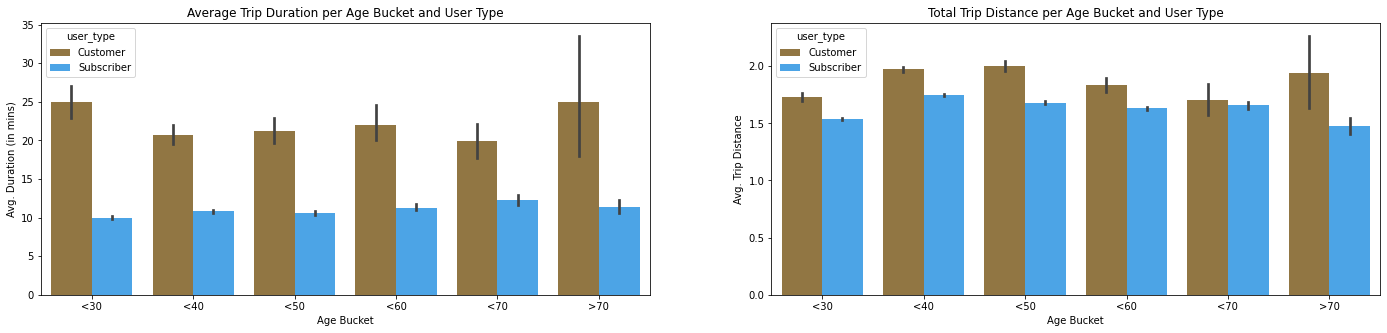

In [7]:
plt.figure(figsize=[24,5])

plt.subplot(1,2,1)
sb.barplot(data=df, x='member_age_bucket', y= 'duration_in_mins',  hue='user_type', palette=[ '#9e7a36', '#33A8FF'])

plt.title('Average Trip Duration per Age Bucket and User Type')
plt.xlabel('Age Bucket')
plt.ylabel('Avg. Duration (in mins)')


plt.subplot(1,2,2)

sb.barplot(data=df, x='member_age_bucket', y= 'trip_distance',  hue='user_type', palette=[ '#9e7a36','#33A8FF'])

plt.title('Total Trip Distance per Age Bucket and User Type')
plt.xlabel('Age Bucket')
plt.ylabel('Avg. Trip Distance')
plt.show()

Tracking the active hours of both user types, we can see that the customer are active on the weekends more than the subscribers. 
However, the subscribers are active all the working weekdays, at peak hours (8:00AM and 5:00PM) which enhance the assumption that most of the subscribers using the company bikes to commute to their workplaces.  





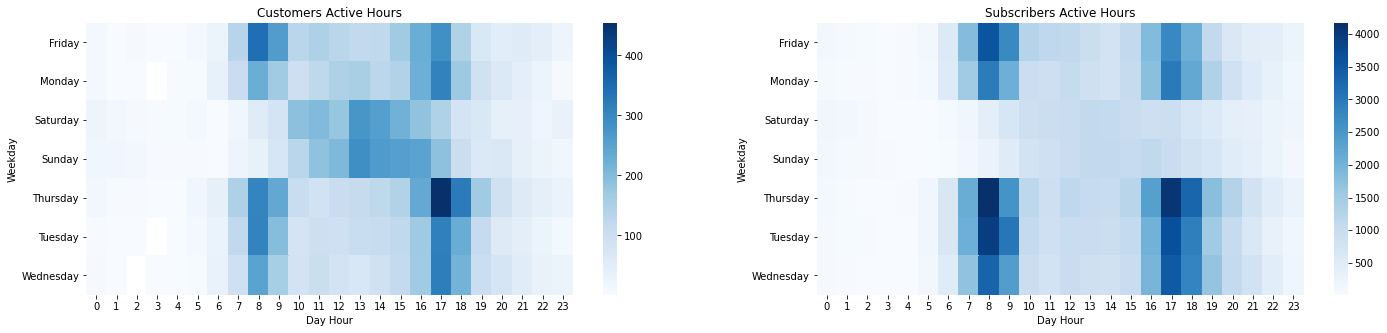

In [8]:
# plotting the daily hours analysis against the weekdays
plt.figure(figsize=[24,5])
fig = plt.subplot(1,2,1)
sb.heatmap(df[df['user_type']=='Customer'].groupby(['trip_start_day', 'trip_start_hour']).size().reset_index(name='trips_count').pivot(index='trip_start_day', columns='trip_start_hour', values='trips_count'), cmap='Blues').set_title('Customers Active Hours')
plt.ylabel('Weekday')
plt.xlabel('Day Hour')

plt.subplot(1,2,2)
sb.heatmap(df[df['user_type']=='Subscriber'].groupby(['trip_start_day', 'trip_start_hour']).size().reset_index(name='trips_count').pivot(index='trip_start_day', columns='trip_start_hour', values='trips_count'), cmap='Blues').set_title('Subscribers Active Hours')
plt.ylabel('Weekday')
plt.xlabel('Day Hour')

plt.show()

## Recommendations
We can conclude that Ford GoBike company has potential subscribers to work on their retention. The customers using the bikes for longer time and farther distance mainly on weekends, and the subscribers use the bikes along the working days for shorter time, nearer distance and more frequent than the customers.  

In [9]:
!jupyter nbconvert Communicating_Data_Findings_Project_Deck.ipynb --to slides --post serve  --no-input --no-prompt


[NbConvertApp] Converting notebook Communicating_Data_Findings_Project_Deck.ipynb to slides
[NbConvertApp] Writing 686766 bytes to Communicating_Data_Findings_Project_Deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\ProgramData\Anaconda3\lib\site-packages\jupyter_core\application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 350, in start
    self.convert_notebooks()
  File "C:\ProgramData\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 524, in convert_notebooks
    self.convert